In [1]:
# importing packages

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeRegressor  
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [2]:
# merge the information of CaptureSite_category to the main table 'train'

df_raw = pd.read_csv('data/Datacleaned_stefanie.csv', sep=',')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18062 entries, 0 to 18061
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Rescue_ID            18062 non-null  object 
 1   Researcher           18062 non-null  int64  
 2   CaptureSite          18062 non-null  int64  
 3   ForagingGround       18062 non-null  object 
 4   CaptureMethod        17976 non-null  object 
 5   Fisher               18062 non-null  int64  
 6   Species              18062 non-null  int64  
 7   CCW_cm               18035 non-null  float64
 8   Weight_Kg            12653 non-null  float64
 9   CaptureSiteCategory  18062 non-null  int64  
 10  Type                 18062 non-null  int64  
 11  catch_fulldate       18062 non-null  object 
 12  catch_year           18062 non-null  int64  
 13  catch_month          18062 non-null  int64  
 14  catch_weekofyear     18062 non-null  int64  
 15  catch_dayofyear      18062 non-null 

<span style=color:tomato>

* keep in mind that after importing the cleaned data csv, all columns with numbers will be set automatically to integers
* change datatypes before these go into the model


In [3]:
df_raw.head()

,Rescue_ID,Researcher,CaptureSite,ForagingGround,CaptureMethod,Fisher,Species,CCW_cm,Weight_Kg,CaptureSiteCategory,Type,catch_fulldate,catch_year,catch_month,catch_weekofyear,catch_dayofyear,catch_dayofweek
0,2000_RE_0060,25,0,ocean,net,1072,6,62.60,NaN,2,1,2000-12-22,2000,12,51,357,4
1,2001_RE_0187,6,0,ocean,net,520,6,31.35,NaN,2,1,2001-10-28,2001,10,43,301,6
2,2001_RE_0197,6,0,ocean,net,1669,5,49.20,NaN,2,1,2001-11-01,2001,11,44,305,3
3,2002_RE_0031,32,0,ocean,net,1798,6,59.00,NaN,2,1,2002-03-11,2002,3,11,70,0
4,2002_RE_0118,25,0,ocean,beached,1918,5,33.00,NaN,2,1,2002-08-08,2002,8,32,220,3


<span style=color:tomato>

### BASELINE MODEL as agreed with Mahmoud and Ester:

* weeks + CaptureSite
* CaptureSite + weeks

#### as well as "add-ons" 
* years + weeks + CaptureSite
* years + month + weeks + CaptureSite

In [4]:
# OUR BASELINE MODEL with WEEK and CaptureSite
#-------------------------------------------------
model_df = df_raw.groupby(['catch_weekofyear', 'CaptureSite'])['Rescue_ID'].count().reset_index()
model_df.columns = ['catch_weekofyear', 'CaptureSite', 'TurtleCount']


# OUR BASELINE MODEL with WEEK and CaptureSite but ordered differently
#------------------------------------------------------------------------
#model_df = df_raw.groupby(['CaptureSite', 'catch_weekofyear'])['Rescue_ID'].count().reset_index()
#model_df.columns = ['CaptureSite', 'catch_weekofyear', 'TurtleCount']


# OUR ADD-ONS MODEL with YEAR and WEEK and CaptureSite
#----------------------------------------------------------
#model_df = df_raw.groupby(['catch_year', 'catch_weekofyear', 'CaptureSite'])['Rescue_ID'].count().reset_index()
#model_df.columns = ['catch_year','catch_weekofyear', 'CaptureSite', 'TurtleCount']


# OUR ADD-ONS MODEL with YEAR and MONTH and WEEK and CaptureSite
#-------------------------------------------------------------------
#model_df = df_raw.groupby(['catch_year', 'catch_month', 'catch_weekofyear', 'CaptureSite'])['Rescue_ID'].count().reset_index()
#model_df.columns = ['catch_year', 'catch_month', 'catch_weekofyear', 'CaptureSite', 'TurtleCount']

model_df


,catch_weekofyear,CaptureSite,TurtleCount
0,1,0,1
1,1,1,19
2,1,2,6
3,1,3,1
4,1,4,5
...,...,...,...
1417,53,21,2
1418,53,23,10
1419,53,24,4
1420,53,25,10


In [5]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1422 entries, 0 to 1421
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   catch_weekofyear  1422 non-null   int64
 1   CaptureSite       1422 non-null   int64
 2   TurtleCount       1422 non-null   int64
dtypes: int64(3)
memory usage: 33.5 KB


<span style=color:plum>

* Time unit "weekofyear" should be converted to object before modelling
* however, there is no difference in RMSE whether weekofyear is in int or object
* according to Alex this might be because our Decision tree is too shallow to see differences

In [6]:
# define the features and target for a simple decision tree model for number of catches (mean) by week/capture site

X = model_df.drop(['TurtleCount'], axis=1).astype(object)    # <--- changes datatype of X features to objects!
y = model_df['TurtleCount']

# Splitting the dataset into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Size of train and test set
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)

X_train:  (1137, 2)
y_train:  (1137,)
X_test:  (285, 2)
y_test:  (285,)


In [7]:
X_train.dtypes

catch_weekofyear    object
CaptureSite         object
dtype: object

In [8]:
y_train.dtypes

dtype('int64')

In [9]:
X_train.head(5)

,catch_weekofyear,CaptureSite
654,25,24
299,12,11
539,21,19
981,37,24
810,31,18


In [10]:
y_train[0:5]

654    7
299    4
539    4
981    6
810    2
Name: TurtleCount, dtype: int64

<span style=color:tomato>

### RandomForestTreeRegression:

* as agreed with Ester and Mahmoud with n_estimators=100 and max_depth=5 (to make it comparable to or SimpleDecTree)

In [11]:
# Create the model with 100 trees
RandForest_model = RandomForestRegressor(n_estimators=100, 
                               random_state=0,
                               max_depth=5, 
                               #max_features = 'sqrt',
                               n_jobs=-1, #number of processors (-1 means all)
                               verbose = 1) #printing out details 

RandForest_model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished


RandomForestRegressor(max_depth=5, n_jobs=-1, random_state=0, verbose=1)

In [12]:
y_pred_test = RandForest_model.predict(X_test)
y_pred_train = RandForest_model.predict(X_train)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [13]:
## JUST COPY PASTE FROM ANOTHER NOTEBOOK - did not modify or run these codes

# n_nodes = []
# max_depths = []

# for ind_tree in RandForest_model.estimators_:
#     n_nodes.append(RandForest_model.tree_.node_count)
#     max_depths.append(RandForest_model.tree_.max_depth)
    
# print(f'Average number of nodes {int(np.mean(n_nodes))}')
# print(f'Average maximum depth {int(np.mean(max_depths))}')

# features = list(X_train.columns)
# fi_RandForest = pd.DataFrame({'feature': features,
#                    'importance': RandForest_model.feature_importances_}).\
#                     sort_values('importance', ascending = False)
# fi_model.head(10)

In [15]:
# Calculate metric on train data:
print('--- Metrics for RandomForest with FEATURES: \n', '-----'*10,'\n', X_train.columns.values,'\n', '-----'*10)
print("Metrics on TRAINING data") 
mse = mean_squared_error(y_train,y_pred_train)
rmse = np.sqrt(mse)
r2 = r2_score(y_train,y_pred_train)
print("R2:", round(r2, 5))
print("MSE:", round(mse, 2))
print("RMSE:", round(rmse, 3))
print("---"*10)
  
# Calculate metric on test data:
print("Metrics on TEST data")  
mse = mean_squared_error(y_test,y_pred_test)
rmse = np.sqrt(mse)
r2 = r2_score(y_test,y_pred_test)
print("R2:", round(r2, 5))
print("MSE:", round(mse, 2))
print("RMSE:", round(rmse, 3))
print("---"*10)

--- Metrics for RandomForest with FEATURES: 
 -------------------------------------------------- 
 ['catch_weekofyear' 'CaptureSite'] 
 --------------------------------------------------
Metrics on TRAINING data
R2: 0.70092
MSE: 59.45
RMSE: 7.711
------------------------------
Metrics on TEST data
R2: 0.69825
MSE: 66.91
RMSE: 8.18
------------------------------


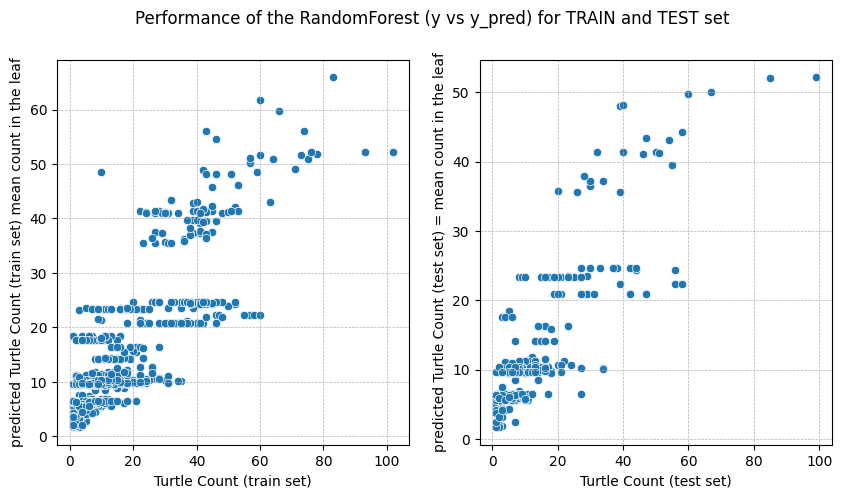

In [16]:
# visualize y
fig, axes = plt.subplots(1,2, figsize=(10,5))
plt.suptitle('Performance of the RandomForest (y vs y_pred) for TRAIN and TEST set')
sns.scatterplot(ax=axes[0], x=y_train, y=y_pred_train)
sns.scatterplot(ax=axes[1], x=y_test, y=y_pred_test)

axes[0].set_xlabel('Turtle Count (train set)')
axes[0].set_ylabel('predicted Turtle Count (train set) mean count in the leaf')
axes[0].grid(linestyle = 'dashed', linewidth = 0.5)
axes[1].set_xlabel('Turtle Count (test set)')
axes[1].set_ylabel('predicted Turtle Count (test set) = mean count in the leaf')

axes[1].grid(linestyle = 'dashed', linewidth = 0.5)

<span style=color:tomato>

### RandomForest with GridSearch:

In [17]:
RandForest_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 5,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 0,
 'verbose': 1,
 'warm_start': False}

In [18]:
# give a range of params to choose:

param_grid = {"criterion" : ["squared_error"],
              "max_depth" : [1,2,3,4,5,6,7,8,9,10,11,15,20]
             }

In [19]:
# perform a lot of RandomForests using GridSearch

GS_RandForest = GridSearchCV(RandForest_model, 
                                   param_grid, 
                                   #scoring='r2',
                                   #scoring='max_error', 
                                   #scoring='explained_variance',
                                   n_jobs=1, 
                                   cv=5)

GS_RandForest.fit(X_train, y_train)    

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parall

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel

GridSearchCV(cv=5,
             estimator=RandomForestRegressor(max_depth=5, n_jobs=-1,
                                             random_state=0, verbose=1),
             n_jobs=1,
             param_grid={'criterion': ['squared_error'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 15,
                                       20]})

In [20]:
# Best score
print('Best score:', round(GS_RandForest.best_score_, 3))
# Best parameters
print('Best parameters:', GS_RandForest.best_params_)

Best score: 0.802
Best parameters: {'criterion': 'squared_error', 'max_depth': 8}


## Decision Tree Model
We ran the same code using the Decision Tree regressor and achieved slightly less optimal results. That's why we opted for the Random Forest as our final model.
### Results :
Best score: 0.759

Best parameters: {'criterion': 'squared_error', 'max_depth': 8}